Auto-regression model components of a signal serially, each one conditionally to the ones already modeled. They rely on the chain rule from probability theory, given $X_1,...,X_T$ random variable, we have

\begin{align}
\forall x_1,..., x_T, P(X_1=x_1,...X_T=x_T) = P(X_1=x_1)P(X_2=x_2|X_1=x_1),...,P(X_T=x_T|X_1=x_1,...,X_{T-1}=x_{t-1})
\end{align}

Deep neural networks are a fitting class of models for such conditional densities when dealing with large dimesion signal.

Given a sequence of r.v. $X_1,...,X_T$ on $\mathbb{R}$, we can represent a conditioning event of the form
\begin{align}
X_{t(1)} = x_1,..., X_{t(N)}=x_N 
\end{align}
with 2 tensors of dimension T: Mask tensor and Value tensor.

<img src = "example_tensors.png" aligh='left'/>



Formalize problem
In what follows, we will consider only finite distributions over ${C}$ real values. Hence we can model a conditional distribution with a mapping that maps a pair
mask / known values to a distribution for the next value of the sequence:

\begin{align}
\mathbb{f}: {\{0, 1\}}^T \times \mathbb{R}^T \to \mathbb{R}^{C}
\end{align}

where the $C outputs values can be either probabilities, or as we will prefer, logits.

This can be generalized beyond categorical distributions by mapping to
parameters of any distribution.


# Training Process

## Input Data

In practice, for each batch, we sample a position to predict for each sample at random,
from which we build the masks, conditioning values, and target values.

The training can be done with mini-batches which
are generated as follows:
We start from a tensor of training sequences,
and pick the position of the value to predict at
random in each, depicted with the red circles.
We create a mask and a value tensor with 1s and
values in each sequence up to the value before
the value to predict and zeros after.
We create the target vector with the values to
predict for each sequence

<img src = "feeding_data.png" aligh='left'/>

## Loss function MLE

With a finite distribution and the output values interpreted as logits, training consists of
maximizing the likelihood of the training samples, hence minimizing

\begin{align}
\mathcal{L\mathbb(f)} & = - \sum_{n}\sum_{t} log  \hat{p}(X_t=x_{n,t}|X_1=x_{n,1},...,X_{t-1}=x_{n,t-1}) \\
& = \sum_{n}\sum_{t} \mathcal{l}(\mathbb{f}((1,...,1,0,...,0), (x_{n,1},...x_{n,t-1},0,...0)),x_{n,t})
\end{align}

where $\mathcal{l}$ is the cross-entropy.

## Generate Data
Given such a model and a sampling procedure sample, then generative process for a full sequence

\begin{align}
x_1 &\leftarrow sample(f(\{\})) \\
x_2 &\leftarrow sample(f(\{X_1= x_1\})) \\
x_3 &\leftarrow sample(f(\{X_1=x_1, X_2=x_2\})) \\
    &... \\
x_T &\leftarrow sample(f(\{X_1=x_1, X_2=x_2,...,X_{T-1}=x_{T-1}\})) 
\end{align}

<img src = "generate_process.png" aligh='left'/>

In [2]:
from src.ar_model import LeNetMNIST 
from src.util import *
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from torchvision import datasets
data_dir = './data'

flatten = False
mnist_train_set = datasets.MNIST(data_dir + '/mnist/', train = True, download = True)
mnist_test_set = datasets.MNIST(data_dir + '/mnist/', train = False, download = True)

train_input = mnist_train_set.data.view(-1, 1, 28, 28).float()
train_target = mnist_train_set.targets
test_input = mnist_test_set.data.view(-1, 1, 28, 28).float()
test_target = mnist_test_set.targets

if flatten:
    train_input = train_input.clone().reshape(train_input.size(0), -1)
    test_input = test_input.clone().reshape(test_input.size(0), -1)

In [4]:
train_input.size()

torch.Size([60000, 1, 28, 28])

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
model = LeNetMNIST(nb_classes=256)

optimizer = torch.optim.SGD(params=model.parameters(),lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [26]:
## Training loop
model = LeNetMNIST(nb_classes=256)
mu, std = train_input.mean(), train_input.std()
batch_size = 256
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.001)
epos = 20
for _ in range(epos):
    for data in train_input.split(batch_size):
        # Make 1d sequences from the images
        sequences = tensor2seq(data)
        nb, len = sequences.size(0), sequences.size(1)
        # Select a random index in each sequence, this is our targets
        idx = torch.randint(len, (nb, 1), device = device)
        targets = sequences.gather(1, idx).view(-1)
        targets = targets.long()
        # Create masks and values accordingly
        tics = torch.arange(len, device = device).view(1, -1).expand(nb, -1)
        masks = seq2tensor((tics < idx.expand(-1, len)).float())
        values = (data.float() - mu) / std * masks
        # Make the input, set the mask and values as two channels
        input = torch.cat((masks, values), 1)
        # Compute the loss and make the gradient step
        output = model(input)
        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [27]:
nb = 25
generated = torch.zeros((nb,) + train_input.shape[1:],device = device, dtype = torch.int64)
sequences = tensor2seq(generated)
tics = torch.arange(sequences.size(1), device = device).view(1, -1).expand(nb, -1)
for t in range(sequences.size(1)):
    masks = seq2tensor((tics < t).float())
    values = (seq2tensor(sequences).float() - mu) / std * masks
    input = torch.cat((masks, values), 1)
    output = model(input)
    dist = torch.distributions.categorical.Categorical(logits = output)
    sequences[:, t] = dist.sample()

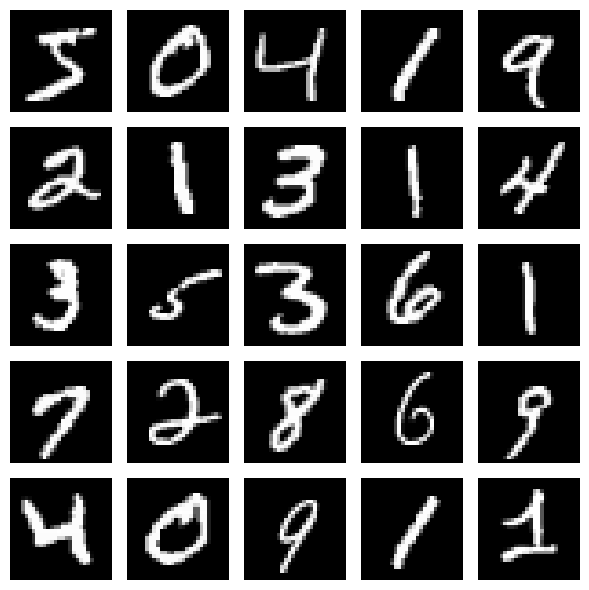

In [30]:
n = 5
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(6, 6))
for i in range(n**2):
    ax = axs[i // n, i % n]
    ax.imshow(sequences[i, :].reshape(28,28), cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
plt.show()